In [12]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter
from tqdm import tqdm
import os

In [13]:
file_path = "datasets\political_leaning.csv"
df = pd.read_csv(file_path)[0:10]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) #split the data into training and testing sets

train_posts = train_data['post'].tolist()
test_posts = test_data['post'].tolist()

print(f"Training set size: {len(train_posts)}")
print(f"Testing set size: {len(test_posts)}")
print(df.columns)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\20220870\AppData\Local\Temp\ipykernel_23368\1470960752.py:1: SyntaxWarning: invalid escape sequence '\p'
  file_path = "datasets\political_leaning.csv"


Training set size: 8
Testing set size: 2
Index(['auhtor_ID', 'post', 'political_leaning'], dtype='object')


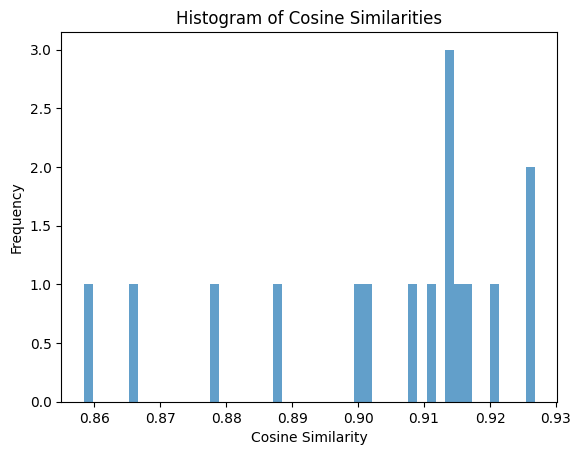

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

vectorizer = CountVectorizer()
train_matrix = vectorizer.fit_transform(train_posts)
test_matrix = vectorizer.transform(test_posts)

train_sample = train_matrix[:1000]
test_sample = test_matrix[:1000]


sample_similarities = cosine_similarity(test_sample, train_sample).flatten()

plt.hist(sample_similarities, bins=50, alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Cosine Similarities")
plt.show()



In [15]:
def top_words_per_dataset(dataset, dataset_name):
    counter = Counter()
    for i, tokens in enumerate(dataset):
        counter.update(tokens)
        if (i + 1) % 500 == 0:
            print(f"[{dataset_name}] Processed {i + 1} rows.")
    return counter

print("Extracting top words from training data...")
train_counter = top_words_per_dataset(train_posts, "Train")
print("Extracting top words from testing data...")
test_counter = top_words_per_dataset(test_posts, "Test")

top_train_words = set([word for word, _ in train_counter.most_common(5000)])
top_test_words = set([word for word, _ in test_counter.most_common(5000)])

overlapping_words = top_train_words.intersection(top_test_words)
unique_train_words = top_train_words - overlapping_words
unique_test_words = top_test_words - overlapping_words

print(f"Number of overlapping words: {len(overlapping_words)}")
print(f"Sample overlapping words: {list(overlapping_words)[:10]}")

vectorizer = CountVectorizer()

print("Fitting vectorizer on training data...")
train_matrix = vectorizer.fit_transform(train_posts)
print("Transforming testing data...")
test_matrix = vectorizer.transform(test_posts)

feature_names = vectorizer.get_feature_names_out()

def compute_cosine_similarity_sparse_with_details(train_matrix, test_matrix, threshold=0.7):
    high_similarity_pairs = []
    similarities_all = []
    batch_size = 100
    for i in range(0, test_matrix.shape[0], batch_size):
        test_batch = test_matrix[i:i + batch_size]
        similarities = cosine_similarity(test_batch, train_matrix)
        similarities_all.extend(similarities.flatten())  # Collect all similarities for plotting
        for test_idx, train_similarities in enumerate(similarities):
            for train_idx, similarity in enumerate(train_similarities):
                if similarity > threshold:
                    high_similarity_pairs.append((train_idx, i + test_idx, similarity))
        print(f"[Similarity] Processed {i + batch_size} test documents.")
    return high_similarity_pairs, similarities_all

print("Computing cosine similarities...")
high_similarity_pairs, similarities_all = compute_cosine_similarity_sparse_with_details(train_matrix, test_matrix)
print(f"Number of high similarity document pairs: {len(high_similarity_pairs)}")
print(f"Sample high similarity pairs (train index, test index, similarity): {high_similarity_pairs[:5]}")

#remove polluted rows
def remove_polluted_rows(df, high_similarity_pairs):
    polluted_test_indices = {test_idx for _, test_idx, _ in high_similarity_pairs}
    polluted_train_indices = {train_idx for train_idx, _, _ in high_similarity_pairs}
    print(f"Removing {len(polluted_train_indices)} polluted training rows...")
    print(f"Removing {len(polluted_test_indices)} polluted testing rows...")

    df_cleaned = df.drop(index=list(polluted_test_indices), errors="ignore").reset_index(drop=True)
    return df_cleaned

df_cleaned = remove_polluted_rows(df, high_similarity_pairs)

#save the cleaned dataset
output_file = os.path.join("datasets", "political_leaning_clean.csv")
df_cleaned.to_csv(output_file, index=False)
print(f"Cleaned dataset saved to '{output_file}'.")

Extracting top words from training data...
Extracting top words from testing data...
Number of overlapping words: 82
Sample overlapping words: ['4', '6', '(', '*', '&', 'V', 'v', 'C', 'x', 'b']
Fitting vectorizer on training data...
Transforming testing data...
Computing cosine similarities...
[Similarity] Processed 100 test documents.
Number of high similarity document pairs: 16
Sample high similarity pairs (train index, test index, similarity): [(0, 0, np.float64(0.900647443266828)), (1, 0, np.float64(0.865896894612126)), (2, 0, np.float64(0.9139609523388802)), (3, 0, np.float64(0.900926711292097)), (4, 0, np.float64(0.9077310381334819))]
Removing 8 polluted training rows...
Removing 2 polluted testing rows...
Cleaned dataset saved to 'datasets\political_leaning_clean.csv'.
